## Yield Spread model
This notebook implements a model to predict yield spreads from reference and trade history data. 

Last modification: After observing the largest errors, we add s condition to the query for the duration elapsed between the current trade and last trade. Currently set to 12 days 

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns


from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor
import lightgbm

from IPython.display import display, HTML
import os

import wandb
from wandb.keras import WandbCallback


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT
from ficc.utils.gcp_storage_functions import upload_data, download_data
from tfidf_features import get_tfidf_features

Extension horovod.torch has not been built: /opt/conda/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
tf.__version__

'2.7.0'

Setting the seed for layer initializer. We want the layers to be initialized with the same values to make the experiments deterministic

In [3]:
layer_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1, seed=10)

Setting the environment variables

In [4]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="eng-reactor-287421-112eb767e1b3.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

Initializing BigQuery client

In [5]:
bq_client = bigquery.Client()

Initializing GCP storage client

In [6]:
storage_client = storage.Client()

Declaring hyper-parameters

In [7]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.0001
BATCH_SIZE = 1000
NUM_EPOCHS = 100

DROPOUT = 0.01
SEQUENCE_LENGTH = 5
NUM_FEATURES = 5

#### Initializing Wandb

In [8]:
# wandb.init(project="yield_spread_model", entity="ficc-ai", name="yield_spread_DDDSDP_no_vol")

#### Query to fetch data

We create the training data from the trades which occured between July and October in 2021. All three trade directions, namely dealer-dealer (D), dealer-sells (S), and dealer-purchases (P) are included. We are limiting the training to bonds whose yield is a positive number less than three. The matrurity description code is restricted to 2 to remove all muni derivaties.



In [9]:
DATA_QUERY = ''' 
SELECT
  *
FROM
  `eng-reactor-287421.auxiliary_views.materialized_trade_history`
WHERE
  yield IS NOT NULL
  AND yield > 0
  AND par_traded >= 10000
  AND trade_date >= '2021-08-01'
  AND trade_date <= '2022-03-23'
  AND maturity_description_code = 2
  AND coupon_type in (8, 4, 10)
  AND capital_type <> 10
  AND default_exists <> TRUE
  AND sale_type <> 4
  AND sec_regulation IS NULL
  AND most_recent_default_event IS NULL
  AND default_indicator IS FALSE
  AND DATETIME_DIFF(trade_datetime,recent[SAFE_OFFSET(0)].trade_datetime,SECOND) < 1000000 -- 12 days to the most recent trade
  AND msrb_valid_to_date > current_date -- condition to remove cancelled trades
ORDER BY
  trade_datetime DESC ''' 

In [10]:
# DATA_QUERY = ''' 
# SELECT
#   *
# FROM
#   `eng-reactor-287421.auxiliary_views.materialized_trade_history`
# WHERE
#   yield IS NOT NULL
#   AND yield > 0
#   AND par_traded >= 10000
#   AND trade_date >= '2021-08-01'
#   AND trade_date <= '2022-03-23'
#   AND maturity_description_code = 2
#   AND (coupon_type = 8 OR coupon_type = 4 OR coupon_type = 10)
#   AND capital_type <> 10
#   AND default_exists <> TRUE
#   AND sale_type <> 4
#   AND sec_regulation IS NULL
#   AND most_recent_default_event IS NULL
#   AND default_indicator IS FALSE
#   AND DATETIME_DIFF(trade_datetime,recent[SAFE_OFFSET(0)].trade_datetime,SECOND) < 1000000 -- 12 days to the most recent trade
#   AND msrb_valid_to_date > current_date -- condition to remove cancelled trades
#   AND (purpose_sub_class is null or 
#        purpose_sub_class <> 6 or 
#        purpose_sub_class <> 20 or 
#        purpose_sub_class <> 21 or 
#        purpose_sub_class <> 22 or 
#        purpose_sub_class <> 57 or 
#        purpose_sub_class <> 44 or 
#        purpose_sub_class <> 106)
#  AND (called_redemption_type is null or called_redemption_type <> 18 or called_redemption_type <> 19)
# ORDER BY
#   trade_datetime DESC ''' 

#### Data Preparation
We grab the data from BigQuery and converts it into a format suitable for input to the model. We save the processed data as a pickle file. If the file already exists we read it from the file. 

The remove_trade_type array contains the trade type that we want to remove from the history. The dealer dealer pickle only contains dealer dealer trades in the trade history

In [12]:
# processed_file = 'processed_data_all_hist_seconds_ago_condition.pkl'
file_timestamp = datetime.now().strftime('%Y-%m-%d-%H:%M')
# processed_file = f"processed_data_ficc_one_trade_hist_{file_timestamp}.pkl"
processed_file = "processed_data_ficc_2022_trades_2022-04-11-16_44.pkl"
# processed_file = "processed_data_ficc_2022_trades_2022-04-19-16_35.pkl"
# processed_file = "processed_data_ficc_2022_trades_2022-04-20-21_26.pkl"
# processed_file = "processed_data_ficc_2022_trades_no_price_delta_2022-04-21-20_50.pkl"
# processed_file = "processed_data_ficc_one_trade_hist_2022-04-05-16_37.pkl"

In [13]:
processed_file

'processed_data_ficc_2022_trades_2022-04-11-16_44.pkl'

In [14]:
%%time
if not os.path.isfile(processed_file):
    data = process_data(DATA_QUERY, 
                        bq_client,
                        SEQUENCE_LENGTH,
                        NUM_FEATURES,
                        f"raw_data_{file_timestamp}.pkl",
                        'FICC',
                        estimate_calc_date=False,
                        remove_short_maturity=True,
                        remove_non_transaction_based=False,
                        remove_trade_type = [],
                        trade_history_delay = 1,
                        min_trades_in_history = 1,
                        process_ratings=False)
                        
    data.to_pickle(processed_file)
    upload_data(storage_client, 'ficc_models_training_data', processed_file)
    #upload_data(storage_client, 'ficc_models_training_data', "raw_data_2021_2022_feb_2022-03-08-18:06.pkl")
else:
    print('Reading from processed file')
    data = pd.read_pickle(processed_file)


Reading from processed file
CPU times: user 1min, sys: 12.7 s, total: 1min 13s
Wall time: 1min 23s


In [15]:
data.purpose_sub_class.fillna(0, inplace=True)

Selecting a subset of features that will be used to train on.

In [16]:
PREDICTORS.remove('maturity_description_code')
CATEGORICAL_FEATURES.remove('maturity_description_code')
PREDICTORS.remove('transaction_type')
CATEGORICAL_FEATURES.remove('transaction_type')

In [17]:
processed_data = data[IDENTIFIERS + PREDICTORS + ['dollar_price','calc_date', 'trade_date','trade_datetime', 'purpose_sub_class', 'called_redemption_type', 'calc_day_cat']]

The process data only removes Dealer-purchase and Dealer-Sell from history. Only Selecting Dealer-Dealer trades as the trade that we want to predict the yield spread for.

In [18]:
# processed_data = processed_data[(processed_data.trade_type == 'D')]

Sanity check on trade type

In [19]:
# processed_data = processed_data[processed_data.rating.isin(['BBB+','A-','A','A+','AA-','AA','AA+','AAA'])]

In [20]:
processed_data = processed_data[~processed_data.purpose_sub_class.isin([6, 20, 21, 22, 44, 57, 90, 106])]

In [21]:
processed_data = processed_data[~processed_data.called_redemption_type.isin([18, 19])]

In [22]:
# PREDICTORS.remove('purpose_sub_class')
# CATEGORICAL_FEATURES.remove('purpose_sub_class')

In [23]:
processed_data.dropna(inplace=True)

#### Fitting encoders to the categorical features. These encoders are then used to encode the categorical features of the train and test set

In [24]:
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

In [25]:
fmax

{'rating': 18,
 'incorporated_state_code': 53,
 'trade_type': 2,
 'purpose_class': 45}

#### Splitting the data into train and test sets



In [43]:
train_dataframe = processed_data[processed_data.trade_date < '04-01-2022']

In [44]:
test_dataframe = processed_data[(processed_data.trade_date >= '04-01-2022') & (processed_data.trade_date <= '04-30-2022')]

In [45]:
# train_index = int(len(processed_data) * (1-TRAIN_TEST_SPLIT))
# train_dataframe = processed_data[train_index:]
# # train_security_descrip = security_description_vectorized[train_index:]
# # train_org_primary = organization_primary_vectorized[train_index:]

# test_dataframe = processed_data[:train_index]
# # test_security_descrip = security_description_vectorized[:train_index]
# # test_org_primary = organization_primary_vectorized[:train_index]
# print(f'Print length of training data frame {len(train_dataframe)}')
# print(f'Pring length of testing data frame {len(test_dataframe)}')

In [46]:
def create_input(df):
    global encoders
    datalist = []
    datalist.append(np.stack(df['trade_history'].to_numpy()))
    
    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

In [47]:
%%time
x_train = create_input(train_dataframe)
y_train = train_dataframe.yield_spread

CPU times: user 2.11 s, sys: 88.7 ms, total: 2.2 s
Wall time: 2.2 s


In [48]:
# x_train.append(train_security_descrip)
# x_train.append(train_org_primary)

In [49]:
%%time
x_test = create_input(test_dataframe)
# x_test.append(test_security_descrip)
# x_test.append(test_org_primary)
y_test = test_dataframe.yield_spread

CPU times: user 251 ms, sys: 0 ns, total: 251 ms
Wall time: 250 ms


#### Adapting Normalization layers to the non categorical features

In [50]:
# Normalization layer for the trade history
trade_history_normalizer = Normalization()
trade_history_normalizer.adapt(x_train[0])

In [51]:
# Normalization layer for the non-categorical and binary features
noncat_binary_normalizer = Normalization()
noncat_binary_normalizer.adapt(x_train[1])

#### Self attention layer

In [52]:
class CustomAttention(tf.keras.layers.Layer):
    def __init__(self, depth):
        super(CustomAttention, self).__init__()
        self.depth = depth
        self.wq = layers.Dense(depth, kernel_initializer=layer_initializer) 
        self.wk = layers.Dense(depth, kernel_initializer=layer_initializer)
        self.wv = layers.Dense(depth, kernel_initializer=layer_initializer)

    def scaled_dot_product_attention(self, q, k, v):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        scaling = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(scaling)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=1) 
        output = tf.matmul(attention_weights, v)
        
        return output
    
    def call(self, q, v):
        k = tf.identity(v)
        
        q = self.wq(q)
        v = self.wv(v)
        k = self.wk(k)
        
        output = self.scaled_dot_product_attention(q, v, k)
        
        return output    

#### Implementation of the model

In [103]:
inputs = []
layer = []

############## INPUT BLOCK ###################
trade_history_input = layers.Input(name="trade_history_input", 
                                   shape=(SEQUENCE_LENGTH,NUM_FEATURES), 
                                   dtype = tf.float32) 

inputs.append(trade_history_input)
inputs.append(layers.Input(
    name="NON_CAT_AND_BINARY_FEATURES",
    shape=(len(NON_CAT_FEATURES + BINARY),)
))


layer.append(noncat_binary_normalizer(inputs[1]))
####################################################


############## TRADE HISTORY MODEL #################

# Adding the time2vec encoding to the input to transformer
lstm_layer = layers.LSTM(50, 
                         activation='tanh',
                         input_shape=(SEQUENCE_LENGTH,NUM_FEATURES),
                         kernel_initializer = layer_initializer,
                         return_sequences = True,
                         name='LSTM')

# lstm_attention_layer = layers.Attention(use_scale=True, name='attention_layer_1')
lstm_attention_layer = CustomAttention(50)

lstm_layer_2 = layers.LSTM(100, 
                           activation='tanh',
                           input_shape=(SEQUENCE_LENGTH,50),
                           kernel_initializer = layer_initializer,
                           return_sequences = False,
                           name='LSTM_2')

lstm_attention_layer_2 = layers.Attention(use_scale= False, name='attention_layer_2')


features = lstm_layer(trade_history_normalizer(inputs[0]))
# features = lstm_attention_layer([features, features])
# TODO add features of the trade that we are trying to predict
features = lstm_attention_layer(features, features)
features = layers.BatchNormalization()(features)
# features = layers.Dropout(DROPOUT)(features)

features = lstm_layer_2(features)
# features = lstm_attention_layer_2([features, features])
features = layers.BatchNormalization()(features)
# features = layers.Dropout(DROPOUT)(features)

trade_history_output = layers.Dense(100, 
                                    activation='relu',
                                    kernel_initializer=layer_initializer)(features)

####################################################

############## REFERENCE DATA MODEL ################
global encoders
for f in CATEGORICAL_FEATURES:
    fin = layers.Input(shape=(1,), name = f)
    inputs.append(fin)
    embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                    output_dim = 15,
                                                                    input_length= 1,
                                                                    name = f + "_embed",
                                                                    embeddings_initializer=layer_initializer)(fin))
    layer.append(embedded)


# security_descrip_input = layers.Input(shape=(len(security_description_vectorized[0]),), name='security_descrip_input')
# inputs.append(security_descrip_input)
# security_embedd = layers.Dense(15,activation='relu',kernel_initializer=layer_initializer,name='security_descrip_shape')(security_descrip_input)
# layer.append(security_embedd)

# org_primary_input = layers.Input(shape=(len(organization_primary_vectorized[0]),), name='org_primary_input')
# inputs.append(org_primary_input)
# org_primary_embed = layers.Dense(15,activation='relu',kernel_initializer=layer_initializer,name='org_primary_embed')(org_primary_input)
# layer.append(org_primary_embed)
    
reference_hidden = layers.Dense(400,activation='relu',kernel_initializer=layer_initializer,name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

reference_hidden = layers.BatchNormalization()(reference_hidden)
reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

reference_hidden2 = layers.Dense(200,activation='relu',kernel_initializer=layer_initializer,name='reference_hidden_2')(reference_hidden)
reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

reference_output = layers.Dense(100,activation='tanh',kernel_initializer=layer_initializer,name='reference_hidden_3')(reference_hidden2)

####################################################


feed_forward_input = layers.concatenate([reference_output, trade_history_output])

hidden = layers.Dense(300,activation='relu',kernel_initializer=layer_initializer)(feed_forward_input)
hidden = layers.BatchNormalization()(hidden)
hidden = layers.Dropout(DROPOUT)(hidden)

hidden2 = layers.Dense(100,activation='tanh',kernel_initializer=layer_initializer)(hidden)
hidden2 = layers.BatchNormalization()(hidden2)
hidden2 = layers.Dropout(DROPOUT)(hidden2)

final = layers.Dense(1,kernel_initializer=layer_initializer)(hidden2)

model = keras.Model(inputs=inputs, outputs=final)

NameError: name 'features_to_predict' is not defined

In [54]:
# model.summary()

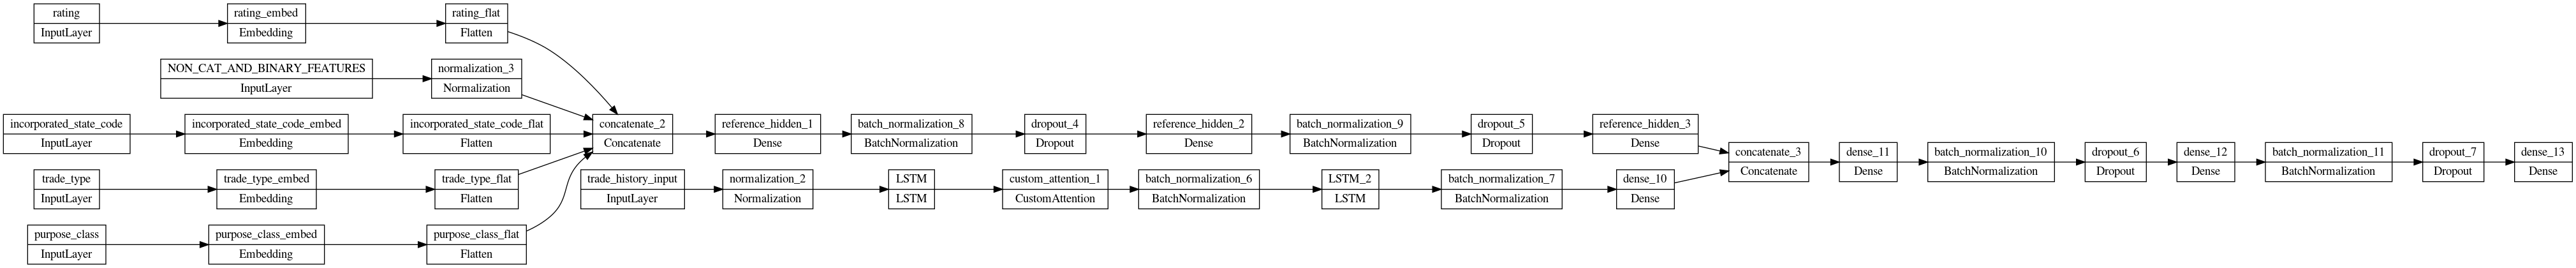

In [55]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [56]:
fit_callbacks = [
#     WandbCallback(),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True,
    )
]

In [57]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError(),
          metrics=[keras.metrics.MeanAbsoluteError()])

In [58]:
%time history = model.fit(x_train,y_train,epochs=100,batch_size=BATCH_SIZE,verbose=1,validation_split=0.1,callbacks=fit_callbacks)

Epoch 1/100
871/871 [==============================] - 14s 12ms/step - loss: 48.9382 - mean_absolute_error: 48.9382 - val_loss: 50.2139 - val_mean_absolute_error: 50.2139
Epoch 2/100
871/871 [==============================] - 9s 11ms/step - loss: 44.9310 - mean_absolute_error: 44.9310 - val_loss: 48.1399 - val_mean_absolute_error: 48.1399
Epoch 3/100
871/871 [==============================] - 9s 11ms/step - loss: 38.7480 - mean_absolute_error: 38.7480 - val_loss: 35.4831 - val_mean_absolute_error: 35.4831
Epoch 4/100
871/871 [==============================] - 9s 11ms/step - loss: 30.4113 - mean_absolute_error: 30.4113 - val_loss: 27.6636 - val_mean_absolute_error: 27.6636
Epoch 5/100
871/871 [==============================] - 9s 11ms/step - loss: 21.3860 - mean_absolute_error: 21.3860 - val_loss: 18.0887 - val_mean_absolute_error: 18.0887
Epoch 6/100
871/871 [==============================] - 9s 11ms/step - loss: 14.6176 - mean_absolute_error: 14.6176 - val_loss: 12.0369 - val_mean_abs

### Test accuracy on the entire test set

In [59]:
_, mae = model.evaluate(x_test, y_test, verbose=1)
print(f"Test loss: {round(mae, 3)}")

3864/3864 [==============================] - 15s 4ms/step - loss: 11.3042 - mean_absolute_error: 11.3042
Test loss: 11.304


### Accuracy on a daily basis

In [60]:
for d in [d for d in pd.date_range(start="04/01/2022",end="04/30/2022",freq='D')]:
    next_day = test_dataframe[(test_dataframe.trade_date == d)
                              & (test_dataframe.trade_type == 'D')
                             & (test_dataframe.quantity >= np.log10(500000))].copy()
    if len(next_day) == 0:
        continue
    next_day_test = create_input(next_day)  
    next_day_preds = model.predict(next_day_test)
    error = next_day.yield_spread - next_day_preds.reshape(-1)
    MAE = np.mean(np.abs(error))
    print(f"Date :{d.date()} MAE:{MAE}" )

Date :2022-04-01 MAE:6.390027080534505
Date :2022-04-04 MAE:5.853248268382365
Date :2022-04-05 MAE:7.9947601816596245
Date :2022-04-06 MAE:7.645889872113548
Date :2022-04-07 MAE:9.173012564834034
Date :2022-04-08 MAE:7.930369471475302


### Removing trades which have a next call date within a year

In [77]:
test_dataframe.trade_date.value_counts()

2022-04-07    24035
2022-04-06    22311
2022-04-05    20351
2022-04-08    20112
2022-04-04    18909
2022-04-01    17927
Name: trade_date, dtype: int64

array([[<AxesSubplot:title={'center':'accrued_days'}>]], dtype=object)

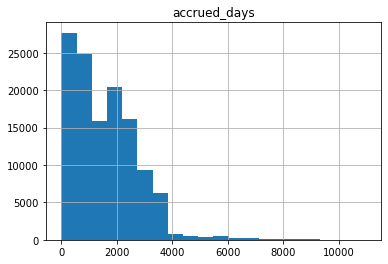

In [80]:
test_dataframe.hist('accrued_days', bins=20)

In [61]:
temp_test =  test_dataframe[(test_dataframe.days_to_call >= np.log10(360))]

In [62]:
x_temp_test_ = create_input(temp_test)
y_temp_test_ = temp_test.yield_spread

In [63]:
_, mae = model.evaluate(x_temp_test_, y_temp_test_, verbose=1)
print(f"Test MAE: {round(mae, 3)}")

2111/2111 [==============================] - 8s 4ms/step - loss: 10.0623 - mean_absolute_error: 10.0623
Test MAE: 10.062


### Test accuracy on true mid


In [68]:
true_mid = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))& (test_dataframe.days_to_call >= np.log10(360))]

In [69]:
len(true_mid)

997

In [70]:
%%time
x_true_mid = create_input(true_mid)
y_true_mid = true_mid.yield_spread

CPU times: user 4.94 ms, sys: 52 µs, total: 4.99 ms
Wall time: 4.61 ms


In [71]:
_, mae = model.evaluate(x_true_mid, y_true_mid, verbose=1)
print(f"Test MAE: {round(mae, 3)}")

32/32 [==============================] - 0s 4ms/step - loss: 6.4355 - mean_absolute_error: 6.4355
Test MAE: 6.436


### Alternative evaluation set

In [89]:
temp_test = test_dataframe[(test_dataframe['accrued_days'] < 500) & (test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(50000))]

In [90]:
len(temp_test)

3936

In [91]:
%%time
x_temp_test = create_input(temp_test)
y_temp_test = temp_test.yield_spread

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 11.4 ms


In [92]:
_, mae = model.evaluate(x_temp_test, y_temp_test, verbose=1)
print(f"Test MAE: {round(mae, 3)}")

123/123 [==============================] - 0s 4ms/step - loss: 6.4937 - mean_absolute_error: 6.4937
Test MAE: 6.494


## Saving the model

In [54]:
file_timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M')

In [55]:
file_timestamp

'2022-04-25-16-58'

In [56]:
with open(f"encoders_{file_timestamp}.pkl",'wb') as file:
    pickle.dump(encoders,file)

In [57]:
f"saved_model_{file_timestamp}"

'saved_model_2022-04-25-16-58'

In [58]:
model.save(f"saved_model_{file_timestamp}")

INFO:tensorflow:Assets written to: saved_model_2022-04-25-16-58/assets


INFO:tensorflow:Assets written to: saved_model_2022-04-25-16-58/assets


In [59]:
import shutil
shutil.make_archive(f"model_{file_timestamp}", 'zip', f"saved_model_{file_timestamp}")

'/home/shayaan/ficc/ml_models/sequence_predictors/model_2022-04-25-16-58.zip'

In [60]:
upload_data(storage_client, 'ficc_encoders', f"encoders_{file_timestamp}.pkl")

File encoders_2022-04-25-16-58.pkl uploaded to ficc_encoders.


In [61]:
upload_data(storage_client, 'ficc_encoders', f"model_{file_timestamp}.zip")

File model_2022-04-25-16-58.zip uploaded to ficc_encoders.


#### Plotting validation loss vs training loss

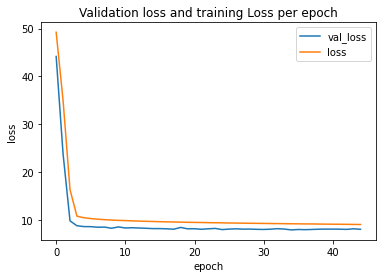

In [62]:
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Plotting trades above a threshold

In [63]:
%time preds = model.predict(x_test)
preds = preds.reshape(len(preds))
error = test_dataframe.yield_spread - preds
MAE = np.mean(np.abs(error))
print(MAE)

CPU times: user 43.5 s, sys: 6.91 s, total: 50.5 s
Wall time: 29.8 s
12.780074124065228


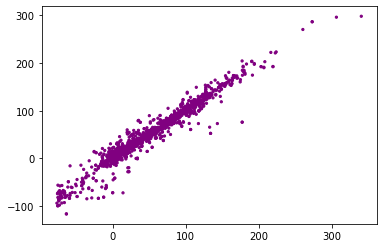

In [64]:
from matplotlib.colors import to_rgb, to_rgba
threshold = 1e6

# plot points with transparency depending on size of trade
def drawpoints(preds, target, train_dataframe):
    #Only draw Dealer-Dealer trades
    r, g, b = to_rgb('purple')
    keep = (10**test_dataframe.quantity > threshold) & (test_dataframe.trade_type == 'D')  # save time by not plotting points that would be invisible
    w = np.minimum( np.array(10**test_dataframe.quantity[keep]), threshold)
    opacity = w/threshold
    color = [(r, g, b, alpha) for alpha in opacity]
    plt.scatter(preds[keep], target[keep], s=5, c=color)
    
plt.figure()
drawpoints(preds, test_dataframe.yield_spread, test_dataframe)

### Baseline using the last yield spread

20.91287688367148


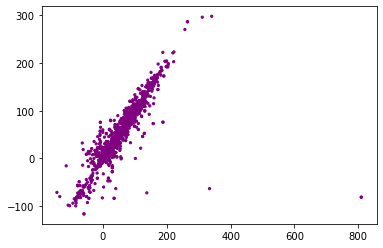

In [65]:
last_ys_preds = test_dataframe.last_yield_spread
error = test_dataframe.yield_spread - last_ys_preds

MAE = np.mean(np.abs(error))
print(MAE)

plt.figure()
drawpoints(last_ys_preds, test_dataframe.yield_spread, test_dataframe)

### Baseline using the last yield spread on dealer dealer true mid trades

13.868684138809424


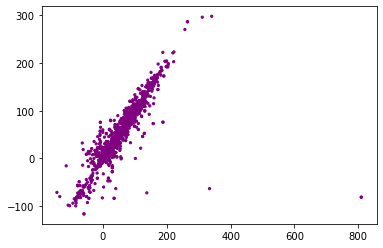

In [66]:
temp_test = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))]
last_ys_preds = temp_test.last_yield_spread
error = temp_test.yield_spread - last_ys_preds

MAE = np.mean(np.abs(error))
print(MAE)

plt.figure()
drawpoints(last_ys_preds, temp_test.yield_spread, temp_test)

### Regression baseline using previous yield spread optimizing MSE

In [67]:
from sklearn.linear_model import LinearRegression

In [68]:
x = train_dataframe.last_yield_spread.values.reshape(-1,1)
y = train_dataframe.yield_spread

In [69]:
reg = LinearRegression().fit(x, y)

In [70]:
print(f"Regression coefficient {reg.coef_} Intercept {reg.intercept_}")

Regression coefficient [0.76332236] Intercept 9.44012605122144


In [71]:
predicted_ys = reg.predict(test_dataframe.last_yield_spread.values.reshape(-1,1))
actual_ys = test_dataframe.yield_spread.values

In [72]:
MAE = np.mean(np.abs(test_dataframe.yield_spread - predicted_ys))
print(MAE)

20.96069509466621


In [73]:
x_range = np.arange(-20,300)
y_straight = x_range.copy()
y_regression = reg.coef_ * x_range + reg.intercept_

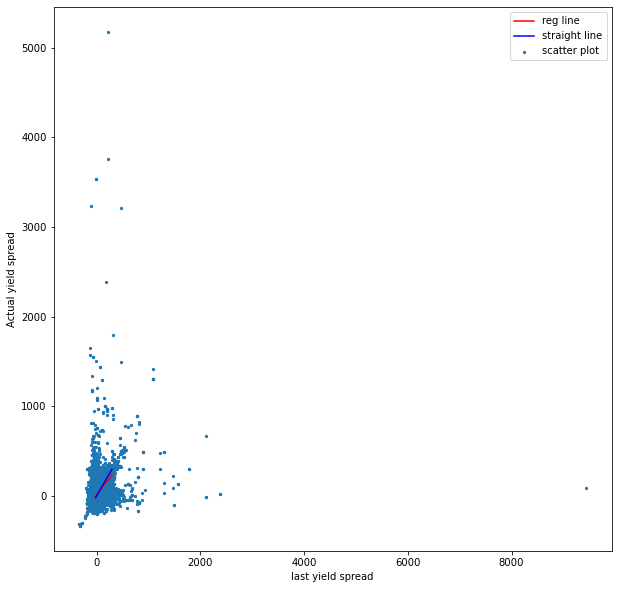

In [74]:
plt.figure(figsize=(10,10))
plt.scatter(test_dataframe.last_yield_spread, actual_ys, s=5)
plt.plot(x_range, y_regression, color='r')
plt.plot(x_range, y_straight, color='b')
plt.xlabel('last yield spread')
plt.ylabel('Actual yield spread')
plt.legend(['reg line','straight line','scatter plot'])
plt.show()

In [75]:
test_dataframe[test_dataframe.yield_spread > 1000][['cusip','trade_date','purpose_sub_class','yield_spread']]

,cusip,trade_date,purpose_sub_class,yield_spread
4222,702282MJ0,2022-04-19,51.0,3542.379226
4223,702282MJ0,2022-04-19,51.0,3542.379226
8168,251130EV8,2022-04-19,11.0,1169.979226
8169,251130EV8,2022-04-19,11.0,1169.979226
22106,546475ST2,2022-04-19,32.0,1437.279226
22109,546475ST2,2022-04-19,32.0,1437.279226
71738,913367DW5,2022-04-18,87.0,3230.680799
81062,91412G5W1,2022-04-18,87.0,1655.537768
81067,91412G5W1,2022-04-18,87.0,1569.037768
91787,345648CZ0,2022-04-18,122.0,3212.280799


### Regression baseline using previous yield spread optimizing MAE

In [76]:
from statsmodels.regression.quantile_regression import QuantReg

In [77]:
q_reg = QuantReg(train_dataframe.last_yield_spread, train_dataframe.yield_spread)

In [78]:
res = q_reg.fit(q=.5)

In [79]:
predicted_yield_spread = res.predict(test_dataframe.last_yield_spread)
actual_yiels_spread = test_dataframe.yield_spread.values

In [80]:
MAE = np.mean(np.abs(actual_yiels_spread - predicted_yield_spread))
print(MAE)

20.912879412617983


In [81]:
print(f'Regression coefficient {res.params[0]}')

Regression coefficient 1.0000001170791721


In [82]:
y_mae_regression = res.params[0] * x_range

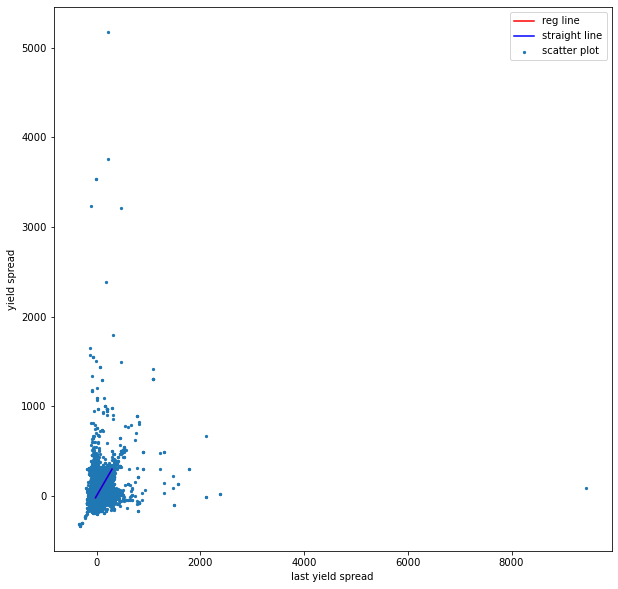

In [83]:
plt.figure(figsize=(10,10))
plt.scatter(test_dataframe.last_yield_spread, actual_yiels_spread, s=5)
plt.plot(x_range, y_mae_regression, color='r')
plt.plot(x_range, y_straight, color='b')
plt.xlabel('last yield spread')
plt.ylabel('yield spread')
plt.legend(['reg line','straight line','scatter plot'])
plt.show()

### LightGBM baseline

In [84]:
def gbmprep(df):
    df[CATEGORICAL_FEATURES ] = df[CATEGORICAL_FEATURES].astype('category')
    df[NON_CAT_FEATURES + BINARY] = df[NON_CAT_FEATURES + BINARY].astype('float64')
    df = df.drop(columns = ['trade_history','yield_spread','calc_date','trade_date','trade_datetime'] + IDENTIFIERS)
    return df

In [85]:
trainlabel = train_dataframe.yield_spread
testlabel = test_dataframe.yield_spread

In [86]:
gbt_td = gbmprep(train_dataframe)

In [87]:
gbtmodel = LGBMRegressor(num_iterations=300, max_depth=12, num_leaves=300, objective='mae', verbosity=-1)

In [88]:
gbtmodel.fit(gbt_td, trainlabel) 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMRegressor(max_depth=12, num_iterations=300, num_leaves=300, objective='mae',
              verbosity=-1)

In [89]:
%%time 
gbt_pred = gbtmodel.predict( gbmprep(test_dataframe) )
delta = testlabel - gbt_pred
print( delta.mean(), delta.abs().mean() )

-11.91221750183249 16.022168845868904
CPU times: user 32.1 s, sys: 0 ns, total: 32.1 s
Wall time: 1.28 s


#### GBM true mid baseline

In [90]:
%%time 
gbt_pred = gbtmodel.predict(gbmprep(temp_test) )
delta = temp_test.yield_spread - gbt_pred
print( delta.mean(), delta.abs().mean() )

-7.692956774193053 12.590884934935358
CPU times: user 413 ms, sys: 0 ns, total: 413 ms
Wall time: 30.1 ms


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

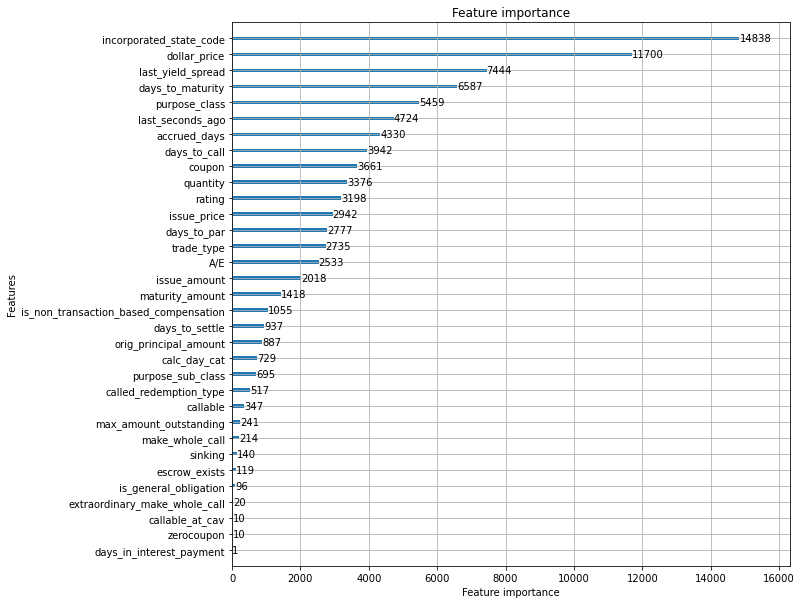

In [91]:
lightgbm.plot_importance(gbtmodel, figsize=(10,10))

#### Analyzing the test set

In [93]:
test_preds = model.predict(x_true_mid)

In [96]:
len(test_preds)

997

In [94]:
evaluation_dataframe = true_mid.copy()
evaluation_dataframe['predicted_yield_spreads'] = test_preds
evaluation_dataframe['delta_yield_spreads'] = evaluation_dataframe.yield_spread - evaluation_dataframe.predicted_yield_spreads

In [101]:
evaluation_dataframe[np.abs(evaluation_dataframe.delta_yield_spreads) > 38.5].to_csv('')

,rtrs_control_number,cusip,callable,sinking,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,callable_at_cav,extraordinary_make_whole_call,make_whole_call,...,trade_history,dollar_price,calc_date,trade_date,trade_datetime,purpose_sub_class,called_redemption_type,calc_day_cat,predicted_yield_spreads,delta_yield_spreads
9479,2022040805772800,59261AUW5,True,True,False,False,False,False,False,False,...,"[[-5.523695579015595, 4.301030158996582, 0.0, ...",102.180,2023-05-15,2022-04-08,2022-04-08 13:12:46,17.0,0.0,0,53.728340,58.380485
31300,2022040707970200,57583PHB8,True,False,False,False,False,False,False,False,...,"[[-42.17381131289616, 4.176091194152832, 0.0, ...",104.405,2023-06-15,2022-04-07,2022-04-07 14:13:07,0.0,0.0,0,-8.679855,-52.616546
31302,2022040707997000,57583PHB8,True,False,False,False,False,False,False,False,...,"[[-42.17381131289616, 4.176091194152832, 0.0, ...",104.355,2023-06-15,2022-04-07,2022-04-07 14:13:04,0.0,0.0,0,-8.679866,-48.416536
31303,2022040707986200,57583PHB8,True,False,False,False,False,False,False,False,...,"[[-42.17381131289616, 4.176091194152832, 0.0, ...",104.405,2023-06-15,2022-04-07,2022-04-07 14:13:04,0.0,0.0,0,-8.679866,-52.616536
89545,2022040503854800,660631YK2,True,False,False,False,True,False,False,False,...,"[[51.49335634589039, 4.544067859649658, 0.0, 1...",80.500,2037-02-01,2022-04-05,2022-04-05 12:02:18,34.0,0.0,2,68.710228,40.651862
107650,2022040405316200,13063B3X8,True,False,False,False,True,False,False,False,...,"[[-10.253548571327684, 4.698969841003418, 0.0,...",102.584,2023-04-01,2022-04-04,2022-04-04 13:15:07,0.0,0.0,0,18.267185,44.879266
119733,2022040108859100,54445CAK9,True,True,False,False,False,False,False,True,...,"[[216.6358279287151, 7.0, 0.0, 1.0, 5.97713439...",100.950,2032-05-15,2022-04-01,2022-04-01 15:57:27,5.0,0.0,0,223.998398,-49.554626


In [98]:
np.mean(evaluation_dataframe.delta_yield_spreads)

0.22257167714387527

array([[<AxesSubplot:title={'center':'delta_yield_spreads'}>]],
      dtype=object)

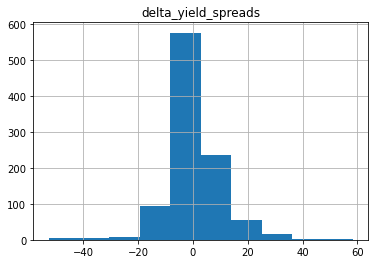

In [95]:
evaluation_dataframe.hist('delta_yield_spreads', bins=10)

In [94]:
evaluation_dataframe.days_to_maturity = 10**evaluation_dataframe.days_to_maturity
evaluation_dataframe.days_to_call = 10**evaluation_dataframe.days_to_call
evaluation_dataframe.quantity = 10**evaluation_dataframe.quantity
evaluation_dataframe.sort_values('delta_yield_spreads', ascending=False)

,rtrs_control_number,cusip,callable,sinking,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,callable_at_cav,extraordinary_make_whole_call,make_whole_call,...,trade_history,dollar_price,calc_date,trade_date,trade_datetime,purpose_sub_class,called_redemption_type,calc_day_cat,predicted_yield_spreads,delta_yield_spreads
21367,2022041910518900,64972B8M0,True,True,False,False,False,False,False,False,...,"[[81.2864350590956, 5.544067859649658, 1.0, 0....",99.998,2023-05-01,2022-04-19,2022-04-19 14:10:51,64.0,0.0,0,60.336079,150.614076
21366,2022041910518900,64972B8M0,True,True,False,False,False,False,False,False,...,"[[81.2864350590956, 5.544067859649658, 1.0, 0....",99.998,2023-05-01,2022-04-19,2022-04-19 14:10:51,64.0,0.0,0,60.336079,150.614076
21381,2022041910521300,64972B8M0,True,True,False,False,False,False,False,False,...,"[[81.2864350590956, 5.544067859649658, 1.0, 0....",99.998,2023-05-01,2022-04-19,2022-04-19 14:10:48,64.0,0.0,0,60.337540,150.612615
21380,2022041910521300,64972B8M0,True,True,False,False,False,False,False,False,...,"[[81.2864350590956, 5.544067859649658, 1.0, 0....",99.998,2023-05-01,2022-04-19,2022-04-19 14:10:48,64.0,0.0,0,60.337540,150.612615
51539,2022041903888200,61075TUV8,True,False,False,False,False,False,False,False,...,"[[42.15448663937559, 6.698969841003418, 0.0, 0...",100.133,2030-07-01,2022-04-19,2022-04-19 11:11:25,122.0,0.0,0,40.127254,83.405515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147885,2022041301722600,650116AW6,True,True,False,False,False,False,False,False,...,"[[193.48602361057837, 4.301030158996582, 0.0, ...",97.625,2046-07-01,2022-04-13,2022-04-13 10:11:21,5.0,0.0,2,174.823669,-88.587477
61807,2022041901482800,650116AW6,True,True,False,False,False,False,False,False,...,"[[187.8341084200318, 4.0, 0.0, 1.0, 4.86093063...",96.092,2046-07-01,2022-04-19,2022-04-19 09:56:28,5.0,0.0,2,177.247681,-101.410175
61808,2022041901482800,650116AW6,True,True,False,False,False,False,False,False,...,"[[187.8341084200318, 4.0, 0.0, 1.0, 4.86093063...",96.092,2046-07-01,2022-04-19,2022-04-19 09:56:28,5.0,0.0,2,177.247681,-101.410175
16545,2022041911680000,64972C5C3,True,True,False,False,False,False,False,False,...,"[[160.15930151057526, 4.176091194152832, 0.0, ...",97.546,2053-11-01,2022-04-19,2022-04-19 14:43:50,64.0,0.0,2,155.194962,-108.195058


#### Isolating trades with error greater than 50 bps

In [95]:
evaluation_dataframe['delta_last_yield_spread'] = np.abs(evaluation_dataframe.yield_spread - evaluation_dataframe.last_yield_spread)

In [96]:
temp_50 = evaluation_dataframe[(evaluation_dataframe.delta_yield_spreads > 20) | (evaluation_dataframe.delta_yield_spreads < -20)  ]
temp_50 = temp_50.sort_values('delta_yield_spreads',ascending=False)
display(temp_50)
temp_50.to_csv('greater_than_50.csv',index=False)

,rtrs_control_number,cusip,callable,sinking,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,callable_at_cav,extraordinary_make_whole_call,make_whole_call,...,dollar_price,calc_date,trade_date,trade_datetime,purpose_sub_class,called_redemption_type,calc_day_cat,predicted_yield_spreads,delta_yield_spreads,delta_last_yield_spread
21366,2022041910518900,64972B8M0,True,True,False,False,False,False,False,False,...,99.998,2023-05-01,2022-04-19,2022-04-19 14:10:51,64.0,0.0,0,60.336079,150.614076,129.663720
21367,2022041910518900,64972B8M0,True,True,False,False,False,False,False,False,...,99.998,2023-05-01,2022-04-19,2022-04-19 14:10:51,64.0,0.0,0,60.336079,150.614076,129.663720
21381,2022041910521300,64972B8M0,True,True,False,False,False,False,False,False,...,99.998,2023-05-01,2022-04-19,2022-04-19 14:10:48,64.0,0.0,0,60.337540,150.612615,129.663720
21380,2022041910521300,64972B8M0,True,True,False,False,False,False,False,False,...,99.998,2023-05-01,2022-04-19,2022-04-19 14:10:48,64.0,0.0,0,60.337540,150.612615,129.663720
51541,2022041903888200,61075TUV8,True,False,False,False,False,False,False,False,...,100.133,2030-07-01,2022-04-19,2022-04-19 11:11:25,122.0,0.0,0,40.127254,83.405515,81.378283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147885,2022041301722600,650116AW6,True,True,False,False,False,False,False,False,...,97.625,2046-07-01,2022-04-13,2022-04-13 10:11:21,5.0,0.0,2,174.823669,-88.587477,107.249832
61807,2022041901482800,650116AW6,True,True,False,False,False,False,False,False,...,96.092,2046-07-01,2022-04-19,2022-04-19 09:56:28,5.0,0.0,2,177.247681,-101.410175,111.996603
61808,2022041901482800,650116AW6,True,True,False,False,False,False,False,False,...,96.092,2046-07-01,2022-04-19,2022-04-19 09:56:28,5.0,0.0,2,177.247681,-101.410175,111.996603
16545,2022041911680000,64972C5C3,True,True,False,False,False,False,False,False,...,97.546,2053-11-01,2022-04-19,2022-04-19 14:43:50,64.0,0.0,2,155.194962,-108.195058,113.159398


Top 20 trades that cause the biggest errors. All the biggest erros come from Dealer Sell trade type

In [97]:
temp_50[['rtrs_control_number','cusip','trade_type','quantity','trade_date','yield_spread','last_yield_spread','delta_yield_spreads','delta_last_yield_spread']][:20]

,rtrs_control_number,cusip,trade_type,quantity,trade_date,yield_spread,last_yield_spread,delta_yield_spreads,delta_last_yield_spread
21366,2022041910518900,64972B8M0,D,5.499999e+05,2022-04-19,210.950155,81.286435,150.614076,129.663720
21367,2022041910518900,64972B8M0,D,5.499999e+05,2022-04-19,210.950155,81.286435,150.614076,129.663720
21381,2022041910521300,64972B8M0,D,5.499999e+05,2022-04-19,210.950155,81.286435,150.612615,129.663720
21380,2022041910521300,64972B8M0,D,5.499999e+05,2022-04-19,210.950155,81.286435,150.612615,129.663720
51541,2022041903888200,61075TUV8,D,1.000000e+06,2022-04-19,123.532769,42.154487,83.405515,81.378283
51539,2022041903888200,61075TUV8,D,1.000000e+06,2022-04-19,123.532769,42.154487,83.405515,81.378283
1528,2022041915007400,914440QM7,D,7.950002e+05,2022-04-19,97.374919,22.039655,68.061534,75.335264
1530,2022041915007300,914440QM7,D,7.950002e+05,2022-04-19,97.374919,22.039655,68.061534,75.335264
1531,2022041915007300,914440QM7,D,7.950002e+05,2022-04-19,97.374919,22.039655,68.061534,75.335264
1529,2022041915007400,914440QM7,D,7.950002e+05,2022-04-19,97.374919,22.039655,68.061534,75.335264


#### Isolating trades with error less than 3 bps

In [98]:
temp_3 = evaluation_dataframe[(evaluation_dataframe.delta_yield_spreads < 3) & (evaluation_dataframe.delta_yield_spreads > -3)  ]
temp_3 = temp_3.sort_values('delta_last_yield_spread',ascending=False)
display(temp_3)
temp_3.to_csv('less_than_3.csv',index=False)

,rtrs_control_number,cusip,callable,sinking,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,callable_at_cav,extraordinary_make_whole_call,make_whole_call,...,dollar_price,calc_date,trade_date,trade_datetime,purpose_sub_class,called_redemption_type,calc_day_cat,predicted_yield_spreads,delta_yield_spreads,delta_last_yield_spread
120172,2022041314106600,544495H64,True,True,False,False,False,False,False,False,...,105.432,2024-07-01,2022-04-13,2022-04-13 16:45:00,80.0,0.0,0,36.907829,1.778194,94.500000
310213,2022040409053000,544495H64,True,True,False,False,False,False,False,False,...,106.299,2024-07-01,2022-04-04,2022-04-04 15:37:00,80.0,0.0,0,29.797756,-1.409693,81.400000
228204,2022040801821500,73358XBA9,True,True,False,False,False,False,False,False,...,98.435,2061-07-15,2022-04-08,2022-04-08 10:32:23,79.0,0.0,2,74.608719,-1.490351,76.364367
160289,2022041210430800,73358WWY6,True,True,False,False,False,False,False,False,...,106.774,2025-05-01,2022-04-12,2022-04-12 14:58:00,79.0,0.0,0,54.440884,-2.201653,69.700000
144221,2022041303818900,13077CY73,True,True,False,False,False,False,False,False,...,107.518,2025-11-01,2022-04-13,2022-04-13 11:14:00,87.0,0.0,0,54.882065,1.984108,65.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319647,2022040404447300,221623UG4,True,True,False,False,True,False,False,False,...,106.177,2024-08-01,2022-04-04,2022-04-04 12:40:22,51.0,0.0,0,43.611298,-0.964684,0.000000
286440,2022040509912000,13049YFP1,True,True,False,False,False,False,False,False,...,103.393,2031-05-15,2022-04-05,2022-04-05 15:55:34,128.0,0.0,0,123.014465,-1.091941,0.000000
177162,2022041202848200,13063CEW6,True,False,False,False,True,False,False,False,...,104.122,2023-09-01,2022-04-12,2022-04-12 10:57:15,0.0,0.0,0,20.236471,1.411321,0.000000
107114,2022041405402900,38122NB84,True,True,True,False,False,True,False,False,...,11.867,2066-06-01,2022-04-14,2022-04-14 12:12:39,118.0,0.0,2,135.708694,-2.995916,0.000000
